# Localization with time of arrival measurements

<a href="https://colab.research.google.com/github/oouabi/gtsam-examples/blob/main/TimeOfArrivalExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Acoustic sensors can be used as a mean to track a moving object. Typically, acoustic measurements are characteristic of the distance between the receiver and an acoustic source. Hence, they convey information on the position of the latter, which can be leveraged for localization. In the next, we will see how gtsam can be used in such a scenario. The following example considers an omnidirectional sound source that periodically emits an acoustic signal while moving. The signals are received by a fixed array of microphones that can synchronously record the signals from which Time of Arrival (ToA) measurements are extracted. The objective is to recover, from the ToA measurements, the trajectory of the moving agent. In this simple example, no odometry information is used, but odometry factors can seamlessly be integrated.

In [1]:
# Install the pre-requisites
%pip -q install gtbook 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gtsam

from gtsam import (LevenbergMarquardtOptimizer, LevenbergMarquardtParams,
                   NonlinearFactorGraph, Point3, Values, noiseModel)
from gtsam_unstable import Event, TimeOfArrival, TOAFactor

# Example trajectory

We start by defining the microphones position and create the ground truth trajectory along with sound events. We first define useful units.

In [3]:
MS = 1e-3 # 1 millisecond in s
CM = 1e-2 # 1 centimeter in m

 Next, we istantiate a functor with a value $v = 330 m.s^{-1}$ for the speed of sound.

In [4]:
TIME_OF_ARRIVAL = TimeOfArrival(330)

We define the positions of four microphones that we constrain to lie in a horizontal plane (*i.e* with constant $z$ coordinate).

In [5]:
height = 0.5
microphones = []
microphones.append(Point3(0, 0, height))
microphones.append(Point3(403 * CM, 0, height))
microphones.append(Point3(403 * CM, 403 * CM, height))
microphones.append(Point3(0, 403 * CM, 2 * height))

K = len(microphones)
for i in range(K):
    print("mic {} = {}".format(i, microphones[i]))

mic 0 = [0.  0.  0.5]
mic 1 = [4.03 0.   0.5 ]
mic 2 = [4.03 4.03 0.5 ]
mic 3 = [0.   4.03 1.  ]


We subsequently create a ground truth trajectory for the moving sound emitter which follows a straight line, and specify the times at which a sound is emitted.

In [6]:
n = 5
groundTruth = []
timeOfEvent = 10

# simulate emitting a sound every second while moving on straight line
for key in range(n):
    groundTruth.append(
        Event(timeOfEvent, 245 * CM + key * 1.0, 201.5 * CM, (212 - 45) * CM))
    timeOfEvent += 1
        
#for event in groundTruth:
#    event.print()

For visualization, we display the agent positions corresponding to an excitation event, along with the microphone array.

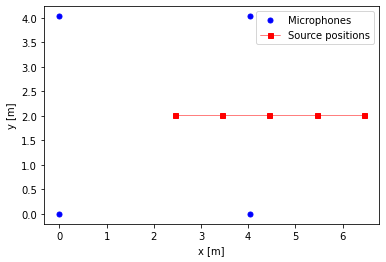

In [7]:
fig = plt.figure()
plt.plot([mic[0] for mic in microphones], [mic[1] for mic in microphones], "b.", markersize=10, label="Microphones")
plt.plot([ev.location()[0] for ev in groundTruth], [ev.location()[1] for ev in groundTruth], "s", color="r", markersize=5, linestyle="-", lw=0.5, label="Source positions")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.legend(); fig.show()

We can now simulate the time of arrival measurements based on the distance between each microphone and the moving sound source. To determine the (noise-free) ToA between microphone $j$ for the $i$-th source position, one may simply use the formula:

$$ z_{i, j} = \frac{d_{i, j}}{v}, $$

where $d_{i, j}$ is the distance between them. Otherwise, the function TIME_OF_ARRIVAL.measure can take care of it.

In [8]:
def simulate_one_toa(microphones, event):
    """Simulate time-of-arrival measurements for a single event."""
    return [TIME_OF_ARRIVAL.measure(event, microphones[i])
            for i in range(len(microphones))]

simulatedTOA = [simulate_one_toa(microphones, event)
        for event in groundTruth]

for key in range(n):
    for i in range(K):
        print("z_{}{} = {} ms".format(key, i, simulatedTOA[key][i] / MS))

z_00 = 10010.245662478956 ms
z_01 = 10008.531002716338 ms
z_02 = 10008.531002716338 ms
z_03 = 10009.824738271 ms
z_10 = 11012.615535847513 ms
z_11 = 11007.276214441754 ms
z_12 = 11007.276214441754 ms
z_13 = 11012.276140565378 ms
z_20 = 12015.22154271807 ms
z_21 = 12007.174542408371 ms
z_22 = 12007.174542408371 ms
z_23 = 12014.941460610633 ms
z_30 = 13017.961192990088 ms
z_31 = 13008.268633130547 ms
z_32 = 13008.268633130547 ms
z_33 = 13017.724455875657 ms
z_40 = 14020.78169909914 ms
z_41 = 14010.17998044382 ms
z_42 = 14010.17998044382 ms
z_43 = 14020.577436670008 ms


# Creation of the nonlinear factor graph

As always, we create a factor graph to solve the problem at hand. 

In [9]:
graph = NonlinearFactorGraph()

# Create a noise model for the TOA error
model = noiseModel.Isotropic.Sigma(1, 0.5 * MS)

K = len(microphones)
key = 0
for toa in simulatedTOA:
    for i in range(K):
        factor = TOAFactor(key, microphones[i], toa[i], model)
        graph.push_back(factor)
    key += 1
        
print(graph.at(0))

  keys = { 0 }
isotropic dim=1 sigma=0.0005
ExpressionFactor with measurement:  10.0102



## Optimization and results

The optimizer needs to be provided an initial trajectory estimate.

In [10]:
initial_estimate = Values()
zero = Event()
for key in range(n):
    TOAFactor.InsertEvent(key, zero, initial_estimate)
print(initial_estimate)

Values with 5 values:
Value 0: (gtsam::Event)
{'time':0, 'location': 0 0 0}
Value 1: (gtsam::Event)
{'time':0, 'location': 0 0 0}
Value 2: (gtsam::Event)
{'time':0, 'location': 0 0 0}
Value 3: (gtsam::Event)
{'time':0, 'location': 0 0 0}
Value 4: (gtsam::Event)
{'time':0, 'location': 0 0 0}



The graph is optimized using the Levenberg-Marquardt optimizer.

In [11]:
params = LevenbergMarquardtParams()
params.setAbsoluteErrorTol(1e-10)
params.setVerbosityLM("SUMMARY")
optimizer = LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()
print("Final Result:\n", result)

Final Result:
 Values with 5 values:
Value 0: (gtsam::Event)
{'time':10, 'location':  2.45 2.015  1.67}
Value 1: (gtsam::Event)
{'time':11, 'location':  3.45 2.015  1.67}
Value 2: (gtsam::Event)
{'time':12, 'location':  4.45 2.015  1.67}
Value 3: (gtsam::Event)
{'time':13, 'location':  5.45 2.015  1.67}
Value 4: (gtsam::Event)
{'time':14, 'location':  6.45 2.015  1.67}



The visual representation of the result shows the excelent matching between estimated and ground truth positions.

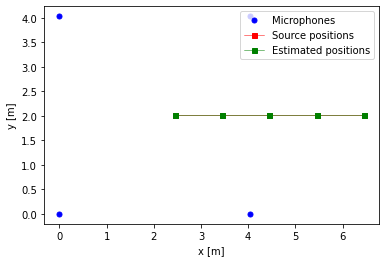

In [12]:
# parsing the result to retrieve the estimated locations
L = result.__repr__().split('\n'); L = [L[ind] for ind in range(2, len(L), 2)]
L = [l.split('location')[1].split()[1:] for l in L]
estimated_trajectory = [ [float(coord.split('}')[0]) for coord in l] for l in L]

# Display
fig = plt.figure()
plt.plot([mic[0] for mic in microphones], [mic[1] for mic in microphones], "b.", markersize=10, label="Microphones")
plt.plot([ev.location()[0] for ev in groundTruth], [ev.location()[1] for ev in groundTruth], "s", color="r", markersize=5, linestyle="-", lw=0.5, label="Source positions")
plt.plot([x[0] for x in estimated_trajectory], [x[1] for x in estimated_trajectory], "s", color="g", markersize=5, linestyle="-", lw=0.5, label="Estimated positions")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.legend(); fig.show()